⫘⫘⫘⫘⫘⫘

Sofia Gabriela Aguilar

036019

ICC CETYS 2026

The Bank Marketing dataset represents a real world business problem in financial institutions: optimizing direct marketing campaigns to promote term deposits. Each customer contact involves operational cost, so the objective is to predict which clients are most likely to subscribe before making the call.

This allows the bank to:

Segment customers more effectively  
Focus resources on high probability clients  
Improve campaign ROI  
Reduce unnecessary contacts  
Enhance overall customer experience  

*This problem is formulated as a supervised binary classification task based on demographic, financial, and historical interaction features.*

Dataset origin:
Janio Martinez Bachmann
https://www.kaggle.com/datasets/janiobachmann/bank-marketing-dataset?resource=download

In [6]:
from pathlib import Path
import sys
!{sys.executable} -m pip install kagglehub

import kagglehub

path = kagglehub.dataset_download("janiobachmann/bank-marketing-dataset")
filepath = Path(path) / Path("bank.csv")

print("Dataset path:", filepath)

Using Colab cache for faster access to the 'bank-marketing-dataset' dataset.
Dataset path: /kaggle/input/bank-marketing-dataset/bank.csv


In [7]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report

In [8]:
data = pd.read_csv(filepath)
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


## Objective Metric Selection

For this analysis, accuracy is selected as the objective metric.

Accuracy measures the overall proportion of correct predictions across both classes. In the context of marketing campaign targeting, accuracy provides a clear and interpretable measure of overall predictive performance, allowing direct comparison between different models.

Although class imbalance may exist in marketing datasets, additional evaluation tools such as the confusion matrix and classification report will be used to analyze class level performance and ensure that the selected model does not disproportionately favor one class.

In [9]:
X = data.drop(columns=["deposit", "duration", "pdays", "poutcome"])
y = data["deposit"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

num_cols = X.select_dtypes(include=["number"]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

X_train.shape

(8929, 13)

## Data Preprocessing

The dataset contains both numeric and categorical features.

To ensure proper training and prevent data leakage, preprocessing is handled within a scikit learn Pipeline and ColumnTransformer

Numeric features: median imputation and standard scaling  
Categorical features: most frequent imputation and one hot encoding  

This ensures that transformations are learned only from the the training data and applied consistently during cross validation.

In [10]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ],
    remainder="drop"
)

## Model 1: Logistic Regression

Logistic Regression is a linear classification model commonly used as a baseline in binary classification tasks.

Hyperparameters are tuned using GridSearchCV with:

- 5 fold cross validation (cv=5)  
- Accuracy as the scoring metric  

The best estimator is selected based on cross validation performance.

In [11]:
pipe_lr = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(max_iter=5000, random_state=42))
])

param_grid_lr = {
    "model__C": [0.1, 1, 10],
    "model__solver": ["liblinear"],
    "model__penalty": ["l2"]
}

grid_lr = GridSearchCV(pipe_lr, param_grid_lr, scoring="accuracy", cv=5, n_jobs=-1)
grid_lr.fit(X_train, y_train)

best_lr = grid_lr.best_estimator_
best_lr_cv = grid_lr.best_score_

best_lr_cv

np.float64(0.6898862927029714)

## Model 2: Random Forest

Random Forest is an ensemble method that builds multiple decision trees and combines their predictions.

GridSearchCV is used to tune key hyperparameters such as:

Number of trees  
Maximum tree depth  
Minimum samples for split  
Maximum features  

*5 fold cross validation is used to optimize accuracy*

In [12]:
pipe_rf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", RandomForestClassifier(random_state=42))
])

param_grid_rf = {
    "model__n_estimators": [100, 200],
    "model__max_depth": [None, 12],
    "model__min_samples_split": [2, 5],
    "model__max_features": ["sqrt"]
}

grid_rf = GridSearchCV(pipe_rf, param_grid_rf, scoring="accuracy", cv=5, n_jobs=-1)
grid_rf.fit(X_train, y_train)

best_rf = grid_rf.best_estimator_
best_rf_cv = grid_rf.best_score_

best_rf_cv

np.float64(0.7243800364490701)

## Model 3: Linear Support Vector Classifier (LinearSVC)

LinearSVC is a linear margin based classifier that seeks to maximize separation between classes.

Hyperparameters such as the regularization parameter and loss function are tuned using GridSearchCV with

5 fold cross validation  
Accuracy as the scoring metric  

The best performing configuration is retained for evaluation.

In [13]:
pipe_svc = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LinearSVC(random_state=42, dual="auto"))
])

param_grid_svc = {
    "model__C": [0.01, 0.1, 1, 10],
    "model__loss": ["hinge", "squared_hinge"]
}

grid_svc = GridSearchCV(pipe_svc, param_grid_svc, scoring="accuracy", cv=5, n_jobs=-1)
grid_svc.fit(X_train, y_train)

best_svc = grid_svc.best_estimator_
best_svc_cv = grid_svc.best_score_

best_svc_cv

np.float64(0.6906702927531596)

## Model Comparison on the Test Set

The three best models are compared using the held out test set.

In addition to test accuracy, training accuracy is reported to evaluate model generalization. The difference between training and test accuracy helps detect

Overfitting: high training accuracy but significantly lower test accuracy  
Underfitting: low performance on both training and test sets  

*The best model is selected based on the highest test accuracy while also considering generalization behavior.*

In [14]:
models = {
    "LogisticRegression": (best_lr, best_lr_cv),
    "RandomForest": (best_rf, best_rf_cv),
    "LinearSVC": (best_svc, best_svc_cv)
}

rows = []

for name, (model, cv_acc) in models.items():
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    acc_train = accuracy_score(y_train, y_pred_train)
    acc_test = accuracy_score(y_test, y_pred_test)

    rows.append({
        "Model": name,
        "Best_CV_Accuracy": cv_acc,
        "Train_Accuracy": acc_train,
        "Test_Accuracy": acc_test,
        "Train_Test_Gap": acc_train - acc_test
    })

results = pd.DataFrame(rows).sort_values(by="Test_Accuracy", ascending=False).reset_index(drop=True)
results

,Model,Best_CV_Accuracy,Train_Accuracy,Test_Accuracy,Train_Test_Gap
0,RandomForest,0.724380,0.796842,0.729960,0.066882
1,LogisticRegression,0.689886,0.694703,0.685625,0.009078
2,LinearSVC,0.690670,0.695823,0.681146,0.014676


## Best Model Selection

Based on test accuracy, the model with the highest performance is selected as the final model.

The train test gap is also reviewed to ensure that the model generalizes well and does not exhibit excessive overfitting.

In [15]:
best_model_name = results.loc[0, "Model"]

best_model = {
    "LogisticRegression": best_lr,
    "RandomForest": best_rf,
    "LinearSVC": best_svc
}[best_model_name]

print("Best model:", best_model_name)

Best model: RandomForest


## Confusion Matrix

The confusion matrix provides a detailed breakdown of prediction outcomes:

True Negatives (correctly predicted "no")  
False Positives (incorrectly predicted "yes")  
False Negatives (missed "yes" cases)  
True Positives (correctly predicted "yes")  

This allows a deeper understanding of model behavior beyond overall accuracy.

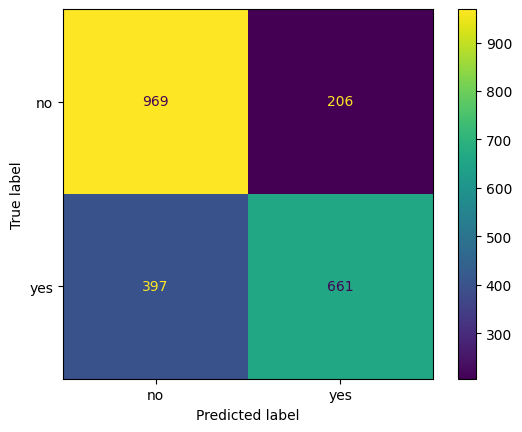

In [16]:
y_pred_best = best_model.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_best)

## Classification Report

The classification report includes:

Precision  
Recall  
F1-score  
Support  

This provides class level performance metrics, allowing evaluation of how well the model performs for both deposit and non-deposit clients.

In [17]:
print(classification_report(y_test, y_pred_best))

              precision    recall  f1-score   support

          no       0.71      0.82      0.76      1175
         yes       0.76      0.62      0.69      1058

    accuracy                           0.73      2233
   macro avg       0.74      0.72      0.72      2233
weighted avg       0.73      0.73      0.73      2233



Three classification models were trained and optimized using GridSearchCV with 5 fold cross validation, optimizing accuracy as the objective metric.

Among the evaluated models, Random Forest achieved the highest test accuracy (~0.73). Although it shows a moderate Train Test gap, its generalization performance remains acceptable.

The confusion matrix and classification report reveal that the model performs better at predicting non deposit clients ("no") than deposit clients ("yes"), indicating slightly lower recall for positive cases.

From a business perspective, the selected model improves decision making when targeting clients for marketing calls. By increasing prediction accuracy, the bank can reduce unnecessary operational costs while focusing efforts on clients with higher likelihood of subscription.

⋆ ˚｡⋆୨♡୧⋆ ˚｡⋆